<a href="https://colab.research.google.com/github/kropotin4/Notebooks/blob/master/exLab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np
import pandas as pd
import random
from numba import njit, jit
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

In [65]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/"
 
N_VAR = 9

In [66]:
MAX_STEP = 2000
REDUCE_E = 1.999
TARGET_E = 0.01

BOOST = 0.1
TRAIN_PR = 0.9

In [67]:
path_end = str(N_VAR).zfill(4) + ".csv"
train_features = pd.read_csv(DATA_PATH + "lab2/train_features_" + path_end, header=None, squeeze=False)
train_labels   = pd.read_csv(DATA_PATH + "lab2/train_labels_"   + path_end, header=None, squeeze=True)
test_features  = pd.read_csv(DATA_PATH + "lab2/test_features_"  + path_end, header=None, squeeze=False)

In [68]:
@njit
def h(x):
    return 1.0 /(1.0 + np.exp(-x)) # sigmoid

@njit
def grad_h(x):
    return x * (1 - x) # sigmoid

@njit
def E(labels, features, teta):
    res = np.zeros(shape=(3))
    cur_val = h(np.dot(features, teta))
    for i in range(0, len(features)):
        res += (cur_val[i] - labels[i])**2

    res /= features.size
    return res

@njit
def E_derivative(labels, features, teta, ind):
    res = np.zeros(shape=(3))
    cur_val = h(np.dot(features, teta))
    grad = grad_h(cur_val)
    for i in range(0, len(features)):
        res += (cur_val[i] - labels[i]) * features[i, ind] * grad[i]

    res /= features.size
    return res

@njit
def predict(features, teta):
    pred = h(np.dot(features, teta))
    res = np.zeros(shape=(len(features)))
    for i in range(len(features)):
        res[i] = pred[i].argmax()
    return res

##@njit
def accurancy(true_labels, pred_labels):
    eq = 0
    for i in range(len(true_labels)):
        eq += true_labels[i] == pred_labels[i]
    return eq / len(true_labels)

In [69]:
def diag_correlation(df):
    # Plot
    plt.figure(figsize=(12, 10), dpi=80)
    sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0,
                annot=True)

    # Decorations
    plt.title('Correlogram of features', fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def plot_pair(df):
    # Plot
    plt.figure(figsize=(10, 8), dpi=80)
    sns.pairplot(df, kind="reg")
    plt.show()

def bars_divirging(df, col1, col2):
    x = df.loc[:, [col1]]

    col_new = str(col1) + str("_mean")

    df[col_new] = (x - x.mean()) / x.std()
    df['colors'] = ['red' if x < 0 else 'green' for x in df[col_new]]
    df.sort_values(col_new, inplace=True)
    df.reset_index(inplace=True)

    # Draw plot
    plt.figure(figsize=(14, 10), dpi=80)
    plt.hlines(y=df.index, xmin=0, xmax=df[col_new], color=df.colors, alpha=0.4, linewidth=5)

    # Decorations
    plt.gca().set(ylabel=col2, xlabel='$Mileage$')
    plt.yticks(df.index, df.c3, fontsize=12)
    plt.title('Diverging Bars', fontdict={'size': 20})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()

In [70]:
def encoding_1tok(labels):
    n_class = int(np.max(labels) - np.min(labels) + 1)
    labels_n = np.zeros(shape=(len(labels), n_class))
    for i in range(len(labels)):
        labels_n[i][int(labels[i])] = 1
    return n_class, labels_n

def encoding_kto1(labels):
    res = np.zeros(shape=(len(labels)))
    for i in range(len(labels)):
        res[i] = labels[i].argmax()
    return res

In [71]:
train_features.columns = ['c'+str(i) for i in range(len(train_features.columns))]
test_features.columns = ['c'+str(i) for i in range(len(test_features.columns))]

In [72]:
#train_features_diag = train_features
#train_features_diag['lab'] = train_labels

#diag_correlation(train_features)

In [73]:
del train_features['c1']
del train_features['c5']
del train_features['c7']
del test_features['c1']
del test_features['c5']
del test_features['c7']


#diag_correlation(train_features)
#plot_pair(train_features)
#bars_divirging(train_features, 'c1', 'c3')

In [74]:
train_labels

0      0.0
1      0.0
2      2.0
3      2.0
4      1.0
      ... 
695    2.0
696    0.0
697    2.0
698    2.0
699    2.0
Name: 0, Length: 700, dtype: float64

In [75]:

#exit(0)

# Shuffle

train_features, train_labels = shuffle(train_features, train_labels)

train_features.reset_index(inplace=True, drop=True)
train_labels.reset_index(inplace=True, drop=True)

#

n_class, labels_k = encoding_1tok(train_labels)

# Split train_features/train_labels to 2 part (first - train, second - check)

train_part = int(len(train_features.index) * TRAIN_PR)

train_features1 = train_features[0:train_part]
train_features2 = train_features[train_part:]
train_features2.reset_index(inplace=True, drop=True) # Reset index for fack pandas.Series

train_labels1 = labels_k[0:train_part]
train_labels2 = labels_k[train_part:]
#train_labels2.reset_index(inplace=True, drop=True)

# NP-version for @jit

train_features_np = train_features.to_numpy()
train_features1_np = train_features1.to_numpy()
train_features2_np = train_features2.to_numpy()

train_labels_np = labels_k #train_labels.to_numpy()
train_labels1_np = train_labels1 #.to_numpy()
train_labels2_np = train_labels2 #.to_numpy()

test_features_np = test_features.to_numpy()

#

n_step = 0
#teta = np.array([np.float64(random.randint(-10, 10)) for i in range(0, len(train_features.columns))])
teta = np.random.rand(len(train_features.columns), n_class)

print("Begin (random) E(teta): " + str(E(train_labels1_np, train_features1_np, teta)))
print("teta: " + str(teta))
print()

mse_list = []
acc_list = []
E1 = 0
E2 = E(train_labels1_np, train_features1_np, teta) * 2
while (True):
    pred = predict(train_features_np, teta)
    #mse_list.append(mean_squared_error(pred, train_labels_np))
    acc_list.append(accurancy(pred, train_labels))
    E1 = E(train_labels1_np, train_features1_np, teta)

    if ((E1 / E2).all() >= REDUCE_E):
        print("Loop exit: small reduce")
        break

    if (E1.all() <= TARGET_E):
        print("Loop exit: achieved target E = " + str(TARGET_E))
        break

    if (n_step >= MAX_STEP):
        print("Loop exit: step number >= MAX_STEP = " + str(MAX_STEP))
        break

    teta = teta - [BOOST*E_derivative(train_labels1_np, train_features1_np, teta, i)
                    for i in range(0, len(train_features.columns))]
    n_step += 1
    #if (n_step % 30 == 0):
    #    print(str(E1))

    E2 = E1


print("End (train part) Acc(teta): " + str(accurancy(predict(train_features1_np, teta), encoding_kto1(train_labels1_np))))
print("End (check part) Acc(teta): " + str(accurancy(predict(train_features2_np, teta), encoding_kto1(train_labels2_np))))
print("End (  all part) Acc(teta): " + str(accurancy(predict(train_features_np, teta), encoding_kto1(train_labels_np))))
print()
print("Step number: " + str(n_step))

<ipython-input-68-a93ba4d151a7>:12: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  cur_val = h(np.dot(features, teta))


Begin (random) E(teta): [0.09109169 0.06890053 0.03808904]
teta: [[0.53708005 0.31499252 0.56776269]
 [0.60185878 0.58937306 0.96840977]
 [0.58273475 0.4842955  0.43775415]
 [0.687013   0.67586812 0.06094182]
 [0.06764168 0.81707113 0.2558069 ]]



<ipython-input-68-a93ba4d151a7>:22: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  cur_val = h(np.dot(features, teta))


Loop exit: step number >= MAX_STEP = 2000


<ipython-input-68-a93ba4d151a7>:32: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  pred = h(np.dot(features, teta))


End (train part) Acc(teta): 0.6206349206349207
End (check part) Acc(teta): 0.5428571428571428
End (  all part) Acc(teta): 0.6128571428571429

Step number: 2000


In [76]:
pd.DataFrame(predict(test_features_np, teta)).to_csv(DATA_PATH + "lab2.csv", index=False)

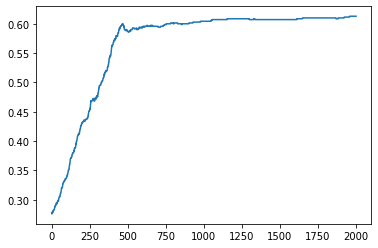

In [77]:
#fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

#ax1.plot(mse_list)
ax2.plot(acc_list)

plt.show()